In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('png', dpi=200)
sns.set_style('darkgrid')
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc, classification_report
import plotly.graph_objects as go

### Gaussian 模型

In [2]:
train_data = pd.read_csv('Data/protrain.csv')
test_data = pd.read_csv('Data/protest.csv')
X_train, y_train = train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values
X_test, y_test = test_data.iloc[:, :-1].values, test_data.iloc[:, -1].values

In [3]:
# 定义朴素贝叶斯模型
model = CatBoostClassifier()

# 定义参数网格
param_grid = {
    "iterations": [100, 200, 300],
    "learning_rate": [0.1, 0.01, 0.001],
    "depth": [3, 4, 5]
}

# 使用网格搜索进行参数调优
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

0:	learn: 0.6456750	total: 131ms	remaining: 13s
1:	learn: 0.6069014	total: 133ms	remaining: 6.5s
2:	learn: 0.5750318	total: 134ms	remaining: 4.33s
3:	learn: 0.5479134	total: 136ms	remaining: 3.26s
4:	learn: 0.5256678	total: 137ms	remaining: 2.61s
5:	learn: 0.5071689	total: 139ms	remaining: 2.18s
6:	learn: 0.4907350	total: 141ms	remaining: 1.88s
7:	learn: 0.4771166	total: 143ms	remaining: 1.65s
8:	learn: 0.4641790	total: 145ms	remaining: 1.46s
9:	learn: 0.4534576	total: 147ms	remaining: 1.32s
10:	learn: 0.4435770	total: 149ms	remaining: 1.2s
11:	learn: 0.4346646	total: 150ms	remaining: 1.1s
12:	learn: 0.4271380	total: 151ms	remaining: 1.01s
13:	learn: 0.4201466	total: 153ms	remaining: 941ms
14:	learn: 0.4139994	total: 155ms	remaining: 877ms
15:	learn: 0.4090914	total: 157ms	remaining: 822ms
16:	learn: 0.4045421	total: 159ms	remaining: 775ms
17:	learn: 0.3998316	total: 160ms	remaining: 730ms
18:	learn: 0.3954769	total: 162ms	remaining: 690ms
19:	learn: 0.3917804	total: 163ms	remaining: 6

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001BEC2F9F790>,
             param_grid={'depth': [3, 4, 5], 'iterations': [100, 200, 300],
                         'learning_rate': [0.1, 0.01, 0.001]})

In [4]:
# 提取不同参数组合的得分
scores = grid_search.cv_results_["mean_test_score"]

# 提取参数组合列表
param_combinations = [f"iterations: {iters}, learning_rate: {lr}, depth: {depth}"
                      for iters in param_grid["iterations"]
                      for lr in param_grid["learning_rate"]
                      for depth in param_grid["depth"]]

# 绘制调参图像
trace = go.Scatter(x=param_combinations, y=scores, mode="markers")
layout = go.Layout(title="Parameter Tuning for CatBoost Classifier",
                   xaxis=dict(title="Parameter Combinations"),
                   yaxis=dict(title="Mean Test Score"), font=dict(family='Times New Roman', size=18))
fig = go.Figure(data=[trace], layout=layout)
fig.write_html('Image/4_6_5_1.html')
fig.show()

In [5]:
lr_model = grid_search.best_estimator_
lr_model

In [6]:
# 预测测试集结果
y_pred = lr_model.predict(X_test)

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 计算ROC曲线数据
fpr, tpr, thresholds = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
auc = roc_auc_score(y_test, y_pred)

In [7]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90     11190
           1       0.77      0.54      0.63      3700

    accuracy                           0.84     14890
   macro avg       0.81      0.74      0.77     14890
weighted avg       0.84      0.84      0.83     14890



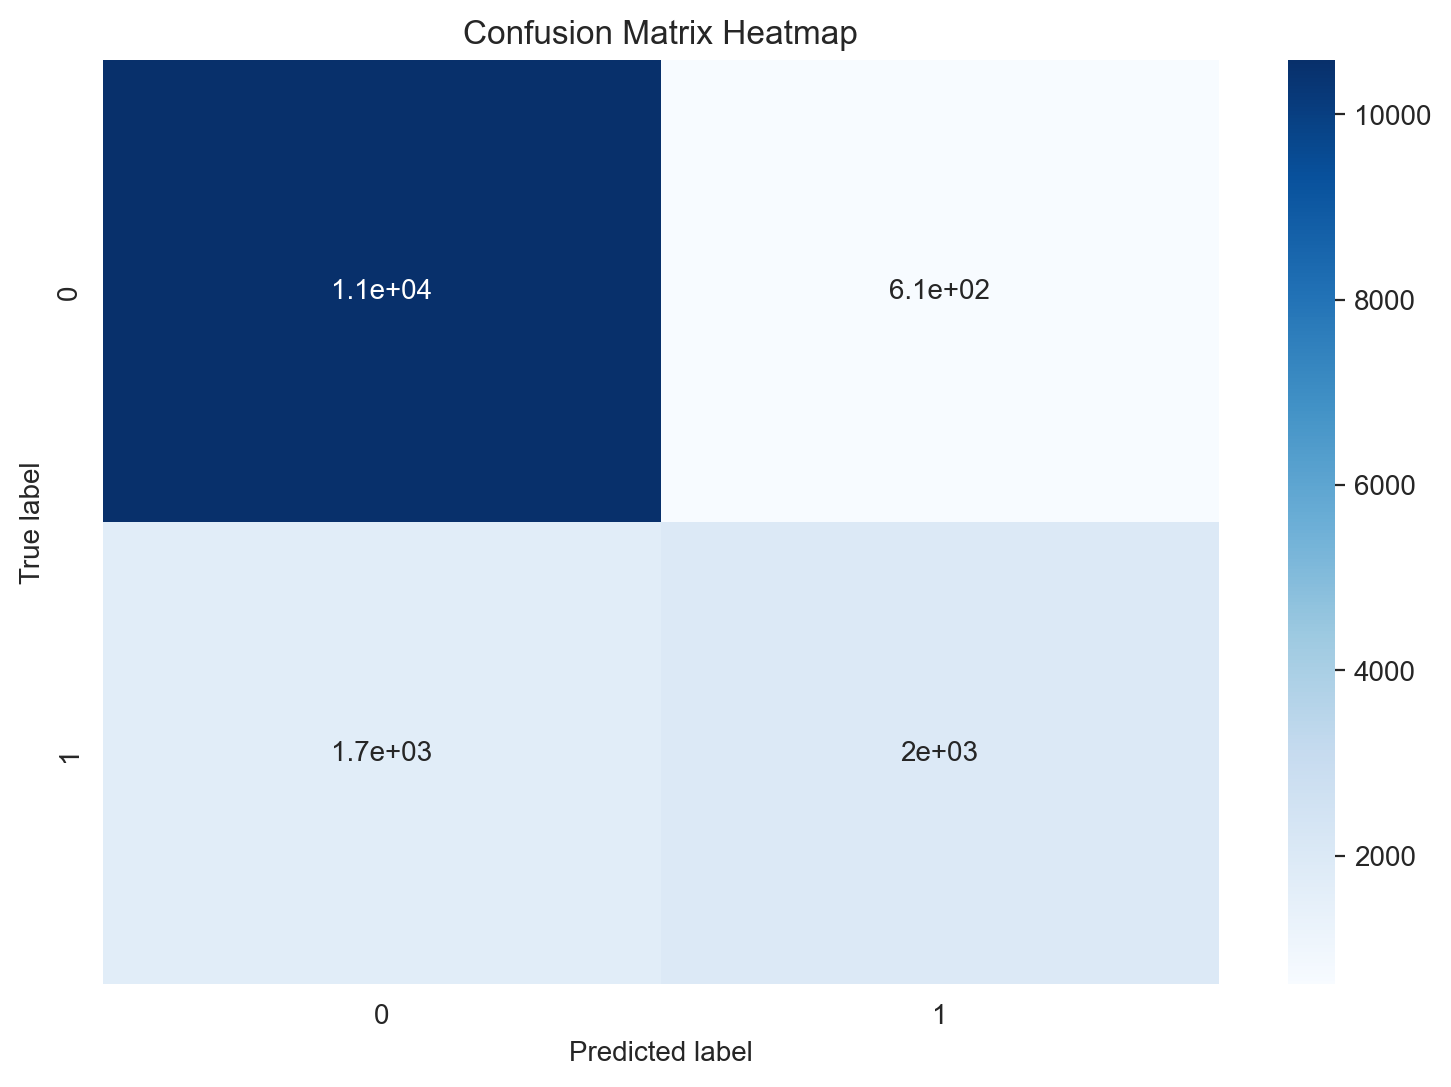

In [8]:
import seaborn as sns

fig = plt.figure(figsize=(9, 6))
# 创建混淆矩阵热力图
sns.heatmap(cm, annot=True, cmap='Blues')

# 设置图表标题和轴标签
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# 显示图表
plt.show()

In [9]:
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

# 计算ROC曲线
roc_auc = auc(fpr, tpr)

# 创建布局
layout = go.Layout(
    title='Receiver Operating Characteristic',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'),
    hovermode='closest',
    width=900, height=600,
    font=dict(family='Times New Roman', size=18)
)

# 创建ROC曲线图形
roc_trace = go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',
    line=dict(color='blue', width=2),
    name='ROC curve (AUC = %0.2f)' % roc_auc
)

# 创建对角线图形
diagonal_trace = go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    line=dict(color='red', width=2, dash='dash'),
    name='Random'
)

# 创建图表数据
data = [roc_trace, diagonal_trace]

# 创建图表
fig = go.Figure(data=data, layout=layout)

fig.write_html('Image/4_6_5_2.html')
# 显示图表
fig.show()

In [10]:
# 执行交叉验证
cv_results = cross_validate(lr_model, X_train, y_train, cv=10, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

# 提取交叉验证结果
cv_accuracy = cv_results['test_accuracy']
cv_precision = cv_results['test_precision']
cv_recall = cv_results['test_recall']
cv_f1 = cv_results['test_f1']
cv_roc = cv_results['test_roc_auc']

# 绘制交叉验证结果的箱线图
cv_metrics_data = pd.DataFrame({
    'Accuracy': cv_accuracy,
    'Precision': cv_precision,
    'Recall': cv_recall,
    'F1': cv_f1,
    'AUC': cv_roc
})

# 绘制交叉验证结果的箱线图
fig = px.box(cv_metrics_data, title='Cross Validation Metrics')
fig.update_layout(
    yaxis_title='Score', showlegend=False,
    font=dict(family='Times New Roman', size=18)
)
fig.write_html('Image/4_6_5_3.html')
fig.show()

0:	learn: 0.6104881	total: 6.01ms	remaining: 1.8s
1:	learn: 0.5530997	total: 11.3ms	remaining: 1.68s
2:	learn: 0.5103657	total: 16.4ms	remaining: 1.62s
3:	learn: 0.4753920	total: 21.8ms	remaining: 1.61s
4:	learn: 0.4477026	total: 27ms	remaining: 1.59s
5:	learn: 0.4288581	total: 32.1ms	remaining: 1.57s
6:	learn: 0.4151400	total: 37.8ms	remaining: 1.58s
7:	learn: 0.4034405	total: 43.1ms	remaining: 1.57s
8:	learn: 0.3955202	total: 48.3ms	remaining: 1.56s
9:	learn: 0.3879082	total: 54ms	remaining: 1.57s
10:	learn: 0.3820245	total: 59.1ms	remaining: 1.55s
11:	learn: 0.3764236	total: 64.6ms	remaining: 1.55s
12:	learn: 0.3718232	total: 70.4ms	remaining: 1.55s
13:	learn: 0.3685395	total: 75.8ms	remaining: 1.55s
14:	learn: 0.3656630	total: 81.2ms	remaining: 1.54s
15:	learn: 0.3634792	total: 87ms	remaining: 1.54s
16:	learn: 0.3610644	total: 92.1ms	remaining: 1.53s
17:	learn: 0.3586929	total: 97.3ms	remaining: 1.52s
18:	learn: 0.3560681	total: 103ms	remaining: 1.52s
19:	learn: 0.3546473	total: 10

### 过采样和欠采样

In [11]:
train_data = pd.read_csv('Data/protrain.csv')
test_data = pd.read_csv('Data/protest.csv')

In [12]:
from imblearn.under_sampling import RandomUnderSampler

In [13]:
X_train, y_train = train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values
X_test, y_test = test_data.iloc[:, :-1].values, test_data.iloc[:, -1].values

In [14]:
# 创建欠采样器
rus = RandomUnderSampler(random_state=42)

# 进行欠采样
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [15]:
lr_model = grid_search.best_estimator_

In [16]:
# 预测测试集结果
y_pred = lr_model.predict(X_test)

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 计算ROC曲线数据
fpr, tpr, thresholds = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
auc = roc_auc_score(y_test, y_pred)

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90     11190
           1       0.77      0.54      0.63      3700

    accuracy                           0.84     14890
   macro avg       0.81      0.74      0.77     14890
weighted avg       0.84      0.84      0.83     14890



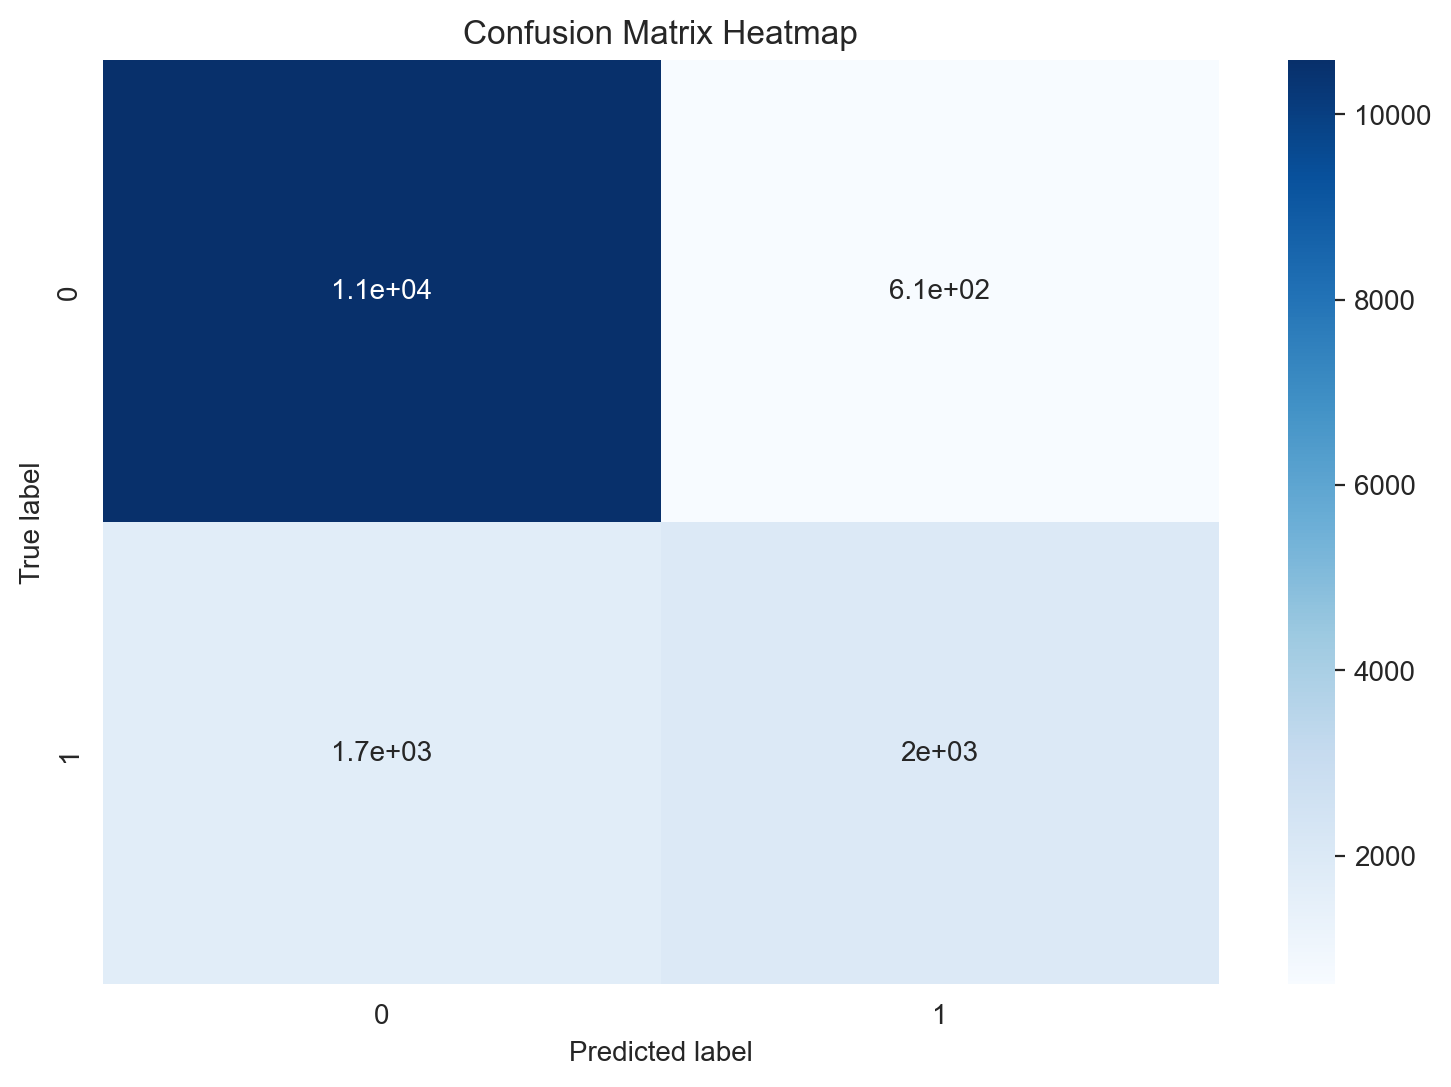

In [18]:
# %%
import seaborn as sns

fig = plt.figure(figsize=(9, 6))
# 创建混淆矩阵热力图
sns.heatmap(cm, annot=True, cmap='Blues')

# 设置图表标题和轴标签
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# 显示图表
plt.show()

In [19]:
# %%
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

# 计算ROC曲线
roc_auc = auc(fpr, tpr)

# 计算ROC曲线
roc_auc = auc(fpr, tpr)

# 创建布局
layout = go.Layout(
    title='Receiver Operating Characteristic',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'),
    hovermode='closest',
    width=900, height=600,
    font=dict(family='Times New Roman', size=18)
)

# 创建ROC曲线图形
roc_trace = go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',
    line=dict(color='blue', width=2),
    name='ROC curve (AUC = %0.2f)' % roc_auc
)

# 创建对角线图形
diagonal_trace = go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    line=dict(color='red', width=2, dash='dash'),
    name='Random'
)

# 创建图表数据
data = [roc_trace, diagonal_trace]

# 创建图表
fig = go.Figure(data=data, layout=layout)

fig.write_html('Image/4_6_5_4.html')
# 显示图表
fig.show()

In [20]:
# 执行交叉验证
cv_results = cross_validate(lr_model, X_train, y_train, cv=10, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

# 提取交叉验证结果
cv_accuracy = cv_results['test_accuracy']
cv_precision = cv_results['test_precision']
cv_recall = cv_results['test_recall']
cv_f1 = cv_results['test_f1']
cv_roc = cv_results['test_roc_auc']

# 绘制交叉验证结果的箱线图
cv_metrics_data = pd.DataFrame({
    'Accuracy': cv_accuracy,
    'Precision': cv_precision,
    'Recall': cv_recall,
    'F1': cv_f1,
    'AUC': cv_roc
})

# 绘制交叉验证结果的箱线图
fig = px.box(cv_metrics_data, title='Cross Validation Metrics')
fig.update_layout(
    yaxis_title='Score', showlegend=False,
    font=dict(family='Times New Roman', size=18)
)
fig.write_html('Image/4_6_5_5.html')
fig.show()

0:	learn: 0.6104881	total: 6.33ms	remaining: 1.89s
1:	learn: 0.5530997	total: 11.7ms	remaining: 1.74s
2:	learn: 0.5103657	total: 16.8ms	remaining: 1.66s
3:	learn: 0.4753920	total: 23.2ms	remaining: 1.72s
4:	learn: 0.4477026	total: 29.1ms	remaining: 1.72s
5:	learn: 0.4288581	total: 35ms	remaining: 1.72s
6:	learn: 0.4151400	total: 40.3ms	remaining: 1.69s
7:	learn: 0.4034405	total: 45.2ms	remaining: 1.65s
8:	learn: 0.3955202	total: 50.4ms	remaining: 1.63s
9:	learn: 0.3879082	total: 56ms	remaining: 1.63s
10:	learn: 0.3820245	total: 61.3ms	remaining: 1.61s
11:	learn: 0.3764236	total: 66.7ms	remaining: 1.6s
12:	learn: 0.3718232	total: 72.1ms	remaining: 1.59s
13:	learn: 0.3685395	total: 77.5ms	remaining: 1.58s
14:	learn: 0.3656630	total: 82.6ms	remaining: 1.57s
15:	learn: 0.3634792	total: 88.2ms	remaining: 1.56s
16:	learn: 0.3610644	total: 93.3ms	remaining: 1.55s
17:	learn: 0.3586929	total: 98.5ms	remaining: 1.54s
18:	learn: 0.3560681	total: 104ms	remaining: 1.54s
19:	learn: 0.3546473	total: 

In [21]:
train_data = pd.read_csv('Data/protrain.csv')
test_data = pd.read_csv('Data/protest.csv')

In [22]:
from imblearn.over_sampling import RandomOverSampler

In [23]:
X_train, y_train = train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values
X_test, y_test = test_data.iloc[:, :-1].values, test_data.iloc[:, -1].values

In [24]:
# 创建过采样器
ros = RandomOverSampler(random_state=42)

# 进行过采样
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [25]:
lr_model = grid_search.best_estimator_

In [26]:
# 预测测试集结果
y_pred = lr_model.predict(X_test)

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 计算ROC曲线数据
fpr, tpr, thresholds = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
auc = roc_auc_score(y_test, y_pred)

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90     11190
           1       0.77      0.54      0.63      3700

    accuracy                           0.84     14890
   macro avg       0.81      0.74      0.77     14890
weighted avg       0.84      0.84      0.83     14890



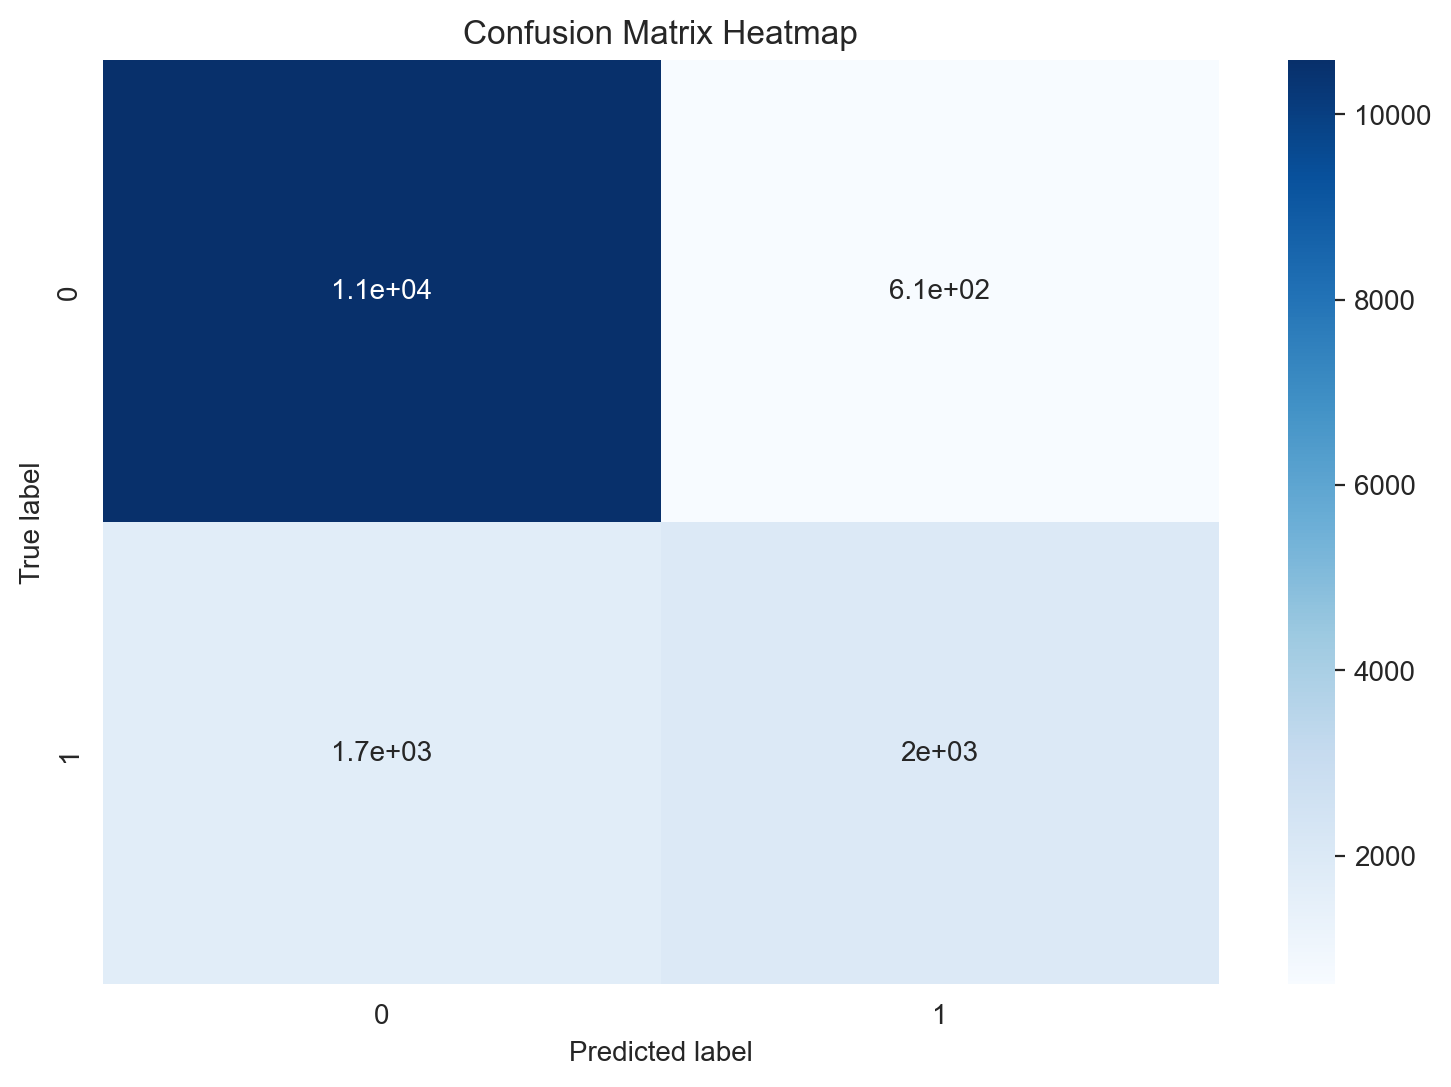

In [28]:
# %%
import seaborn as sns

fig = plt.figure(figsize=(9, 6))
# 创建混淆矩阵热力图
sns.heatmap(cm, annot=True, cmap='Blues')

# 设置图表标题和轴标签
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# 显示图表
plt.show()

In [29]:
# %%
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

# 计算ROC曲线
roc_auc = auc(fpr, tpr)

# 计算ROC曲线
roc_auc = auc(fpr, tpr)

# 创建布局
layout = go.Layout(
    title='Receiver Operating Characteristic',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'),
    hovermode='closest',
    width=900, height=600,
    font=dict(family='Times New Roman', size=18)
)

# 创建ROC曲线图形
roc_trace = go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',
    line=dict(color='blue', width=2),
    name='ROC curve (AUC = %0.2f)' % roc_auc
)

# 创建对角线图形
diagonal_trace = go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    line=dict(color='red', width=2, dash='dash'),
    name='Random'
)

# 创建图表数据
data = [roc_trace, diagonal_trace]

# 创建图表
fig = go.Figure(data=data, layout=layout)

fig.write_html('Image/4_6_5_6.html')
# 显示图表
fig.show()

In [30]:
# 执行交叉验证
cv_results = cross_validate(lr_model, X_train, y_train, cv=10, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

# 提取交叉验证结果
cv_accuracy = cv_results['test_accuracy']
cv_precision = cv_results['test_precision']
cv_recall = cv_results['test_recall']
cv_f1 = cv_results['test_f1']
cv_roc = cv_results['test_roc_auc']

# 绘制交叉验证结果的箱线图
cv_metrics_data = pd.DataFrame({
    'Accuracy': cv_accuracy,
    'Precision': cv_precision,
    'Recall': cv_recall,
    'F1': cv_f1,
    'AUC': cv_roc
})

# 绘制交叉验证结果的箱线图
fig = px.box(cv_metrics_data, title='Cross Validation Metrics')
fig.update_layout(
    yaxis_title='Score', showlegend=False,
    font=dict(family='Times New Roman', size=18)
)
fig.write_html('Image/4_6_5_7.html')
fig.show()

0:	learn: 0.6104881	total: 7.23ms	remaining: 2.16s
1:	learn: 0.5530997	total: 13.1ms	remaining: 1.96s
2:	learn: 0.5103657	total: 19.3ms	remaining: 1.91s
3:	learn: 0.4753920	total: 24.9ms	remaining: 1.84s
4:	learn: 0.4477026	total: 30.7ms	remaining: 1.81s
5:	learn: 0.4288581	total: 37ms	remaining: 1.81s
6:	learn: 0.4151400	total: 42.8ms	remaining: 1.79s
7:	learn: 0.4034405	total: 48.3ms	remaining: 1.76s
8:	learn: 0.3955202	total: 54.4ms	remaining: 1.76s
9:	learn: 0.3879082	total: 60.2ms	remaining: 1.74s
10:	learn: 0.3820245	total: 65.9ms	remaining: 1.73s
11:	learn: 0.3764236	total: 72ms	remaining: 1.73s
12:	learn: 0.3718232	total: 77.7ms	remaining: 1.72s
13:	learn: 0.3685395	total: 83.7ms	remaining: 1.71s
14:	learn: 0.3656630	total: 89.8ms	remaining: 1.71s
15:	learn: 0.3634792	total: 95.8ms	remaining: 1.7s
16:	learn: 0.3610644	total: 102ms	remaining: 1.69s
17:	learn: 0.3586929	total: 107ms	remaining: 1.68s
18:	learn: 0.3560681	total: 113ms	remaining: 1.67s
19:	learn: 0.3546473	total: 11